In [ ]:
import pandas as pd
from tqdm import tqdm
df = pd.read_parquet('postech_company_project.parquet')


In [ ]:
df.head()

In [ ]:
df = df.drop(['YEAR_YYYY', 'MONTH_YYYYMM'], axis=1)

columns_to_drop = ['PARTS_NO1', 'PARTS_NO2', 'PARTS_NO3', 'PARTS_NO4', 'PARTS_NO5',
                   'PREV_PARTS_NO1', 'PREV_PARTS_NO2', 'PREV_PARTS_NO3', 'PREV_PARTS_NO4', 'PREV_PARTS_NO5',
                   'PARTS_DESC1', 'PARTS_DESC2', 'PARTS_DESC3', 'PARTS_DESC4', 'PARTS_DESC5',
                   'PREV_PARTS_DESC1', 'PREV_PARTS_DESC2', 'PREV_PARTS_DESC3', 'PREV_PARTS_DESC4', 'PREV_PARTS_DESC5']

df = df.drop(columns_to_drop, axis=1)
columns_to_drop = ['KEY_PARTS1', 'KEY_PARTS2', 'KEY_PARTS3', 'KEY_PARTS4', 'KEY_PARTS5',
                   'PREV_KEY_PARTS1', 'PREV_KEY_PARTS2', 'PREV_KEY_PARTS3', 'PREV_KEY_PARTS4', 'PREV_KEY_PARTS5',
                   'KEY_PARTS_REMARK1', 'KEY_PARTS_REMARK2', 'KEY_PARTS_REMARK3', 'KEY_PARTS_REMARK4', 'KEY_PARTS_REMARK5',
                   'PREV_KEY_PARTS_REMARK1', 'PREV_KEY_PARTS_REMARK2', 'PREV_KEY_PARTS_REMARK3', 'PREV_KEY_PARTS_REMARK4', 'PREV_KEY_PARTS_REMARK5']

df = df.drop(columns_to_drop, axis=1)

print(df)

In [ ]:
df.head()

 "RECEIPT_NUMBER" 및 "PREV_RECEIPT_NUMBER" 열에서 "LGE_REC_" 부분 제거 및 문자열을 숫자로 변환
 기존 데이터를 바탕으로 다음 재수리가 발생하는지 확인 할때 숫자값만을 이용해서 인덱스로 빠르게 데이터 가공하기 위함

In [ ]:
df['RECEIPT_NUMBER'] = df['RECEIPT_NUMBER'].str.replace('LGE_REC_', '').astype(int, errors='ignore')
df['PREV_RECEIPT_NUMBER'] = df['PREV_RECEIPT_NUMBER'].str.replace('LGE_REC_', '').astype(int, errors='ignore')

In [ ]:
df.set_index('RECEIPT_NUMBER', inplace=True)

In [ ]:
df['NEXT_RECLAIM'] = 0  # "NEXT_RECLAIM" 열을 초기화

for index, row in tqdm(df.iterrows(), total=len(df)):
    prev_receipt_number = row['PREV_RECEIPT_NUMBER']
    if not pd.isna(prev_receipt_number):
        prev_receipt_number = int(prev_receipt_number)
        if prev_receipt_number in df.index:
            df.at[prev_receipt_number, 'NEXT_RECLAIM'] = 1

In [ ]:
print(df.columns)

각 데이터의 유니크값 확인

In [ ]:
unique_values = df.nunique()
for column_name, unique_count in unique_values.items():
    unique_data = df[column_name].unique()
    print(f"Column: {column_name}, Unique Count: {unique_count}")
    print(unique_data)
    print()

엔지니어 숫자 확인

In [ ]:
engineer_counts = df.groupby('CENTER_CODE')['ENGINEER_CODE'].unique()
print(engineer_counts)


1명이상의 엔지니어 숫자 확인

In [ ]:
result = df.groupby('CENTER_CODE').agg(
    ENGINEER_COUNT=('ENGINEER_CODE', 'nunique'),
    SUBSIDIARY_NAME=('SUBSIDIARY_NAME', 'first')
)

# 1개인 CENTER_CODE 제외
filtered_result = result[result['ENGINEER_COUNT'] > 1]
print(filtered_result)

센터별 엔지니어 숫자와 재수리 비율 확인

In [ ]:
result = df.groupby('CENTER_CODE').agg(
    ENGINEER_COUNT=('ENGINEER_CODE', 'nunique'),
    SUBSIDIARY_NAME=('SUBSIDIARY_NAME', 'first'),
    RECLAIM_SUM=('RECLAIM', 'sum')
)
result['RECLAIM_RATIO'] = result['RECLAIM_SUM'] / result['ENGINEER_COUNT']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.boxplot(x='RECLAIM_RATIO', data=result)
plt.xlabel('RECLAIM_RATIO')
plt.show()

In [ ]:
# 날짜 형식으로 변환
df['REPAIR_START_DATE'] = pd.to_datetime(df['REPAIR_START_DATE'], format='%Y%m%d')
df['REPAIR_END_DATE'] = pd.to_datetime(df['REPAIR_END_DATE'], format='%Y%m%d')

# 수리 걸린 시간 계산
df['REPAIR_DURATION'] = df['REPAIR_END_DATE'] - df['REPAIR_START_DATE']

엔지니어별 Load 계산

In [ ]:
def format_date(date_str):
    date_obj = pd.to_datetime(date_str, format='%Y%m%d')
    week_number = date_obj.strftime('%U')
    formatted_date = date_obj.strftime('%Y') + 'W' + week_number
    return formatted_date

df['REPAIR_START_DATE'] = df['REPAIR_START_DATE'].progress_apply(format_date)

In [ ]:
for index, row in tqdm(df.iterrows(), total=len(df)):
    week = row['REPAIR_START_DATE']
    engineer_code = row['ENGINEER_CODE']
    if engineer_code not in df.index:
        df.loc[engineer_code] = 0
    df.at[engineer_code, week] += 1

In [ ]:
for index, row in tqdm(df.iterrows(), total=len(df)):
    engineer_code = row['ENGINEER_CODE']
    repair_start_date = row['REPAIR_START_DATE']
    
    load = engineer_load_dict.get(engineer_code, {}).get(repair_start_date, None)
    if load is not None:
        df.at[index, 'ENGINEER_LOAD'] = load

In [ ]:
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X와 y 설정
X = df.drop(columns=['NEXT_RECLAIM']).values
y = df['NEXT_RECLAIM'].values


# 트레인 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# TabNet 모델 정의
clf = TabNetClassifier(verbose=2) 

# 모델 훈련
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], max_epochs=100)

# 모델 평가
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy * 100:.2f}%')



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, cohen_kappa_score

# 모델 평가
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
confusion = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'ROC AUC: {roc_auc * 100:.2f}%')
print(f'Confusion Matrix:\n{confusion}')
print(f'Kappa Score: {kappa * 100:.2f}%')

Test accuracy: 97.42%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%
ROC AUC: 74.36%
Confusion Matrix:
[[2704563       0]
 [  71694       0]]
Kappa Score: 0.00%

In [ ]:
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X와 y 설정
X = df.drop(columns=['NEXT_RECLAIM']).values
y = df['NEXT_RECLAIM'].values


# 클래스 가중치 설정
class_weights = {0: 1, 1: 10}  # 예시에서는 클래스 1에 대해 높은 가중치를 줌

# 트레인 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# TabNet 모델 정의
clf = TabNetClassifier(verbose=1) 


# 모델 훈련, weights 매개변수를 통해 클래스 가중치 설정
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], max_epochs=100, weights=class_weights)

# 모델 평가
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
confusion = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'ROC AUC: {roc_auc * 100:.2f}%')
print(f'Confusion Matrix:\n{confusion}')
print(f'Kappa Score: {kappa * 100:.2f}%')

saved_model_path = "tabnet_model231109_2.pth"
clf.save_model(saved_model_path)
print(f"Model saved at {saved_model_path}")

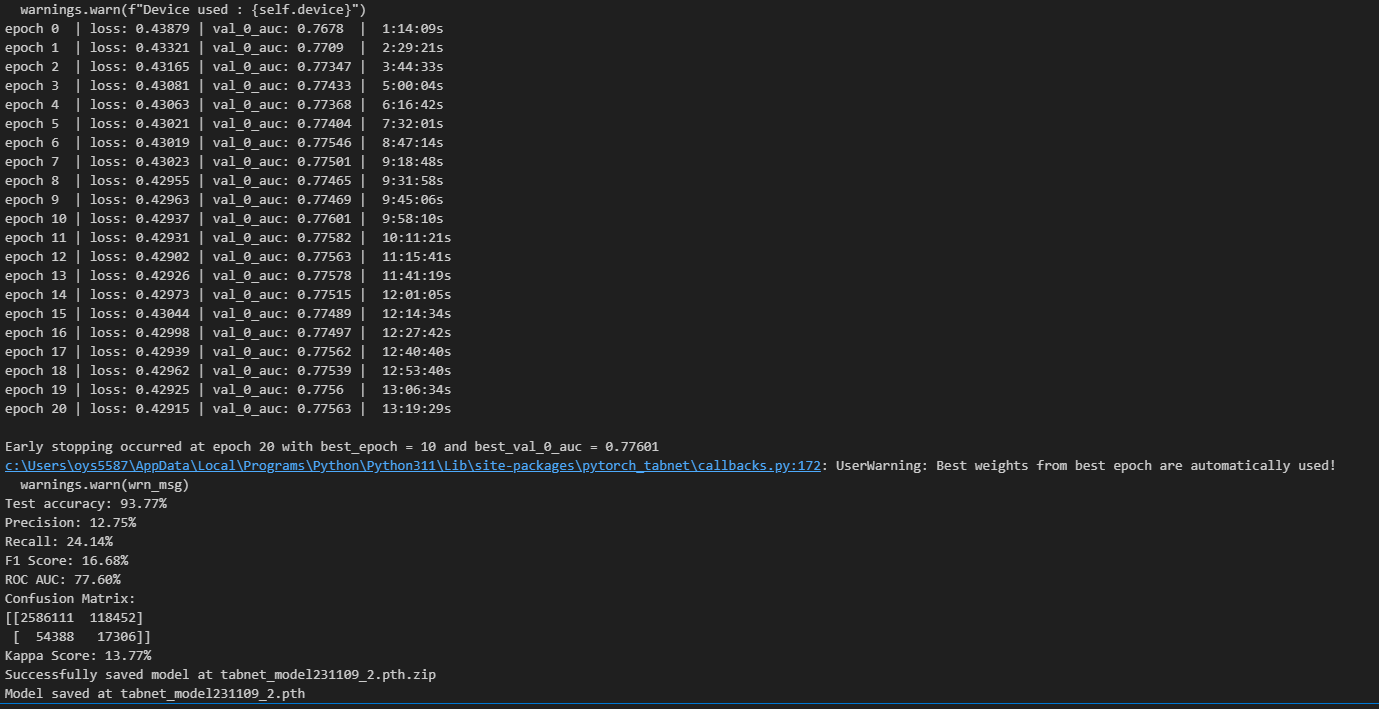

In [ ]:
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X와 y 설정
X = df.drop(columns=['NEXT_RECLAIM']).values
y = df['NEXT_RECLAIM'].values


# 클래스 가중치 설정
class_weights = {0: 1, 1: 5}  # 예시에서는 클래스 1에 대해 높은 가중치를 줌

# 트레인 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# TabNet 모델 정의
clf = TabNetClassifier(verbose=1) 


# 모델 훈련, weights 매개변수를 통해 클래스 가중치 설정
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], max_epochs=100, weights=class_weights)

# 모델 평가
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
confusion = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'ROC AUC: {roc_auc * 100:.2f}%')
print(f'Confusion Matrix:\n{confusion}')
print(f'Kappa Score: {kappa * 100:.2f}%')

saved_model_path = "tabnet_model231109_3.pth"
clf.save_model(saved_model_path)
print(f"Model saved at {saved_model_path}")

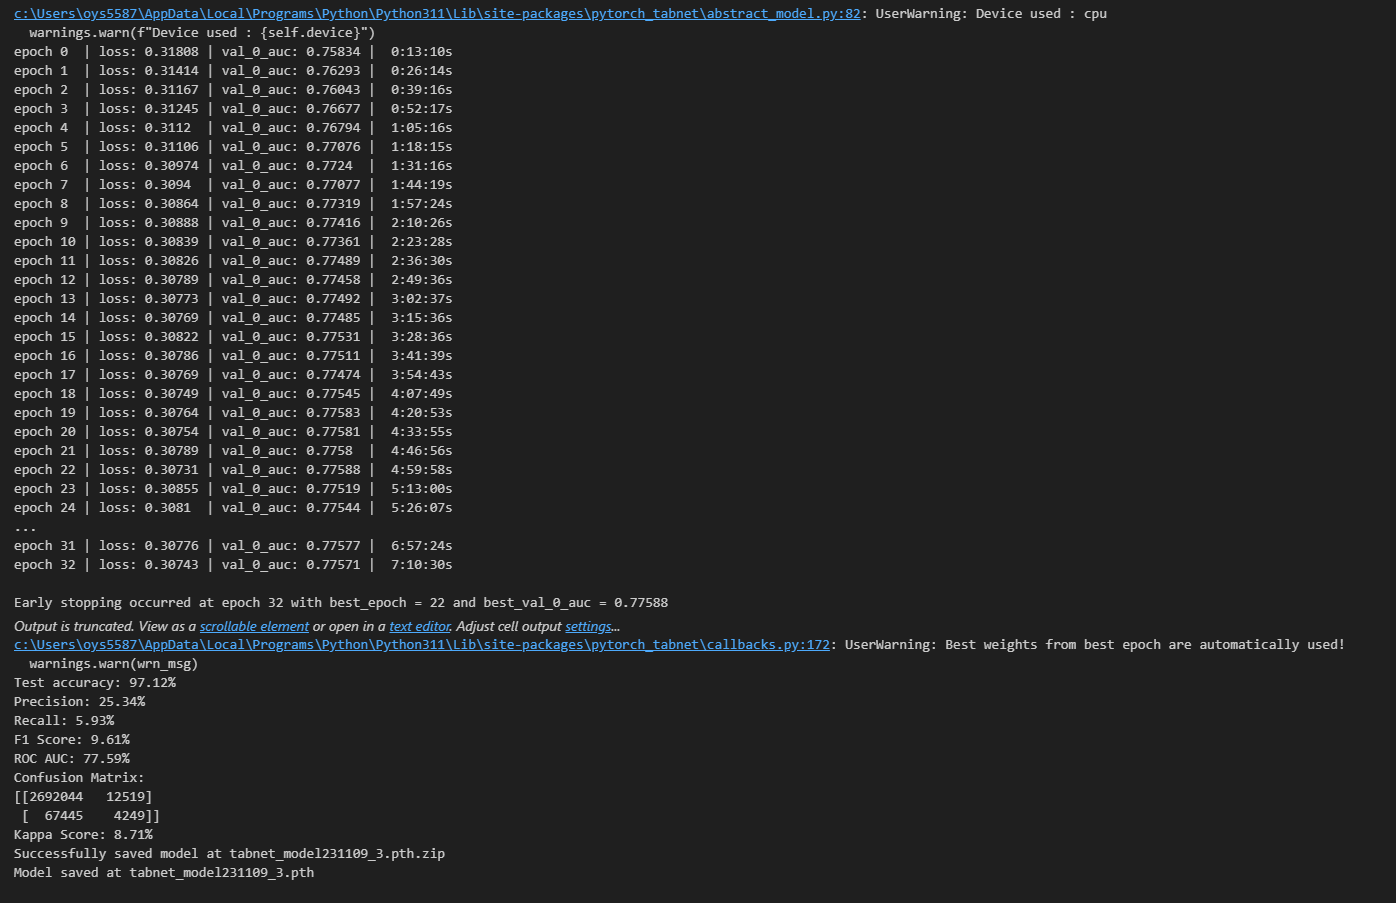

In [ ]:
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X와 y 설정
X = df.drop(columns=['NEXT_RECLAIM']).values
y = df['NEXT_RECLAIM'].values


# 클래스 가중치 설정
class_weights = {0: 1, 1: 15}  # 예시에서는 클래스 1에 대해 높은 가중치를 줌

# 트레인 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# TabNet 모델 정의
clf = TabNetClassifier(verbose=1) 


# 모델 훈련, weights 매개변수를 통해 클래스 가중치 설정
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], max_epochs=100, weights=class_weights)

# 모델 평가
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
confusion = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'ROC AUC: {roc_auc * 100:.2f}%')
print(f'Confusion Matrix:\n{confusion}')
print(f'Kappa Score: {kappa * 100:.2f}%')

saved_model_path = "tabnet_model231109_4.pth"
clf.save_model(saved_model_path)
print(f"Model saved at {saved_model_path}")

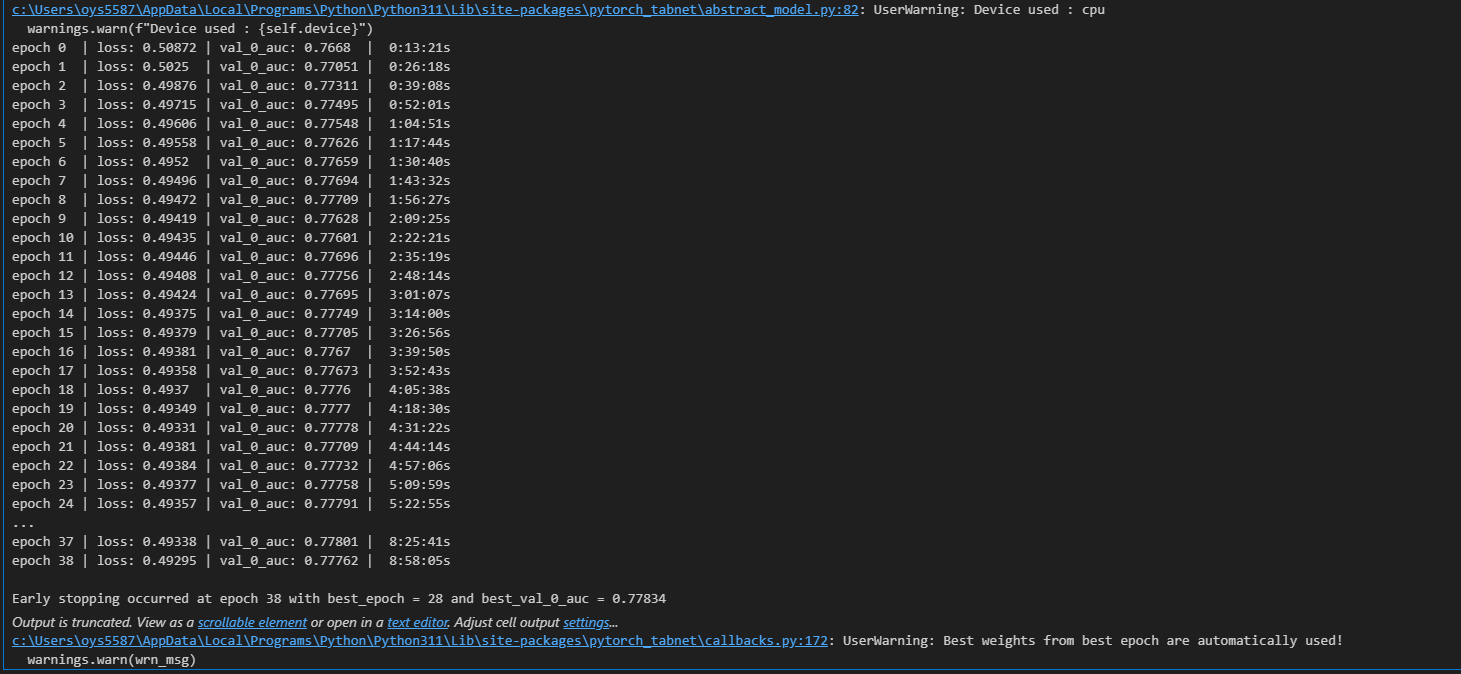

In [ ]:
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X와 y 설정
X = df.drop(columns=['NEXT_RECLAIM']).values
y = df['NEXT_RECLAIM'].values


# 클래스 가중치 설정
class_weights = {0: 1, 1: 50}  # 예시에서는 클래스 1에 대해 높은 가중치를 줌

# 트레인 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TabNet 모델 정의
clf = TabNetClassifier(cat_idxs=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], cat_dims=[2, 2, 5, 23, 19056, 278, 182, 3074, 81, 627, 10, 8, 28622, 305],verbose=1) 


# 모델 훈련, weights 매개변수를 통해 클래스 가중치 설정
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], max_epochs=3, weights=class_weights)

# 모델 평가
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
confusion = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'ROC AUC: {roc_auc * 100:.2f}%')
print(f'Confusion Matrix:\n{confusion}')
print(f'Kappa Score: {kappa * 100:.2f}%')

saved_model_path = "tabnet_model231109_7.pth"
clf.save_model(saved_model_path)
print(f"Model saved at {saved_model_path}")
feature_importances = clf.feature_importances_


print(feature_importances)
print(df.columns)


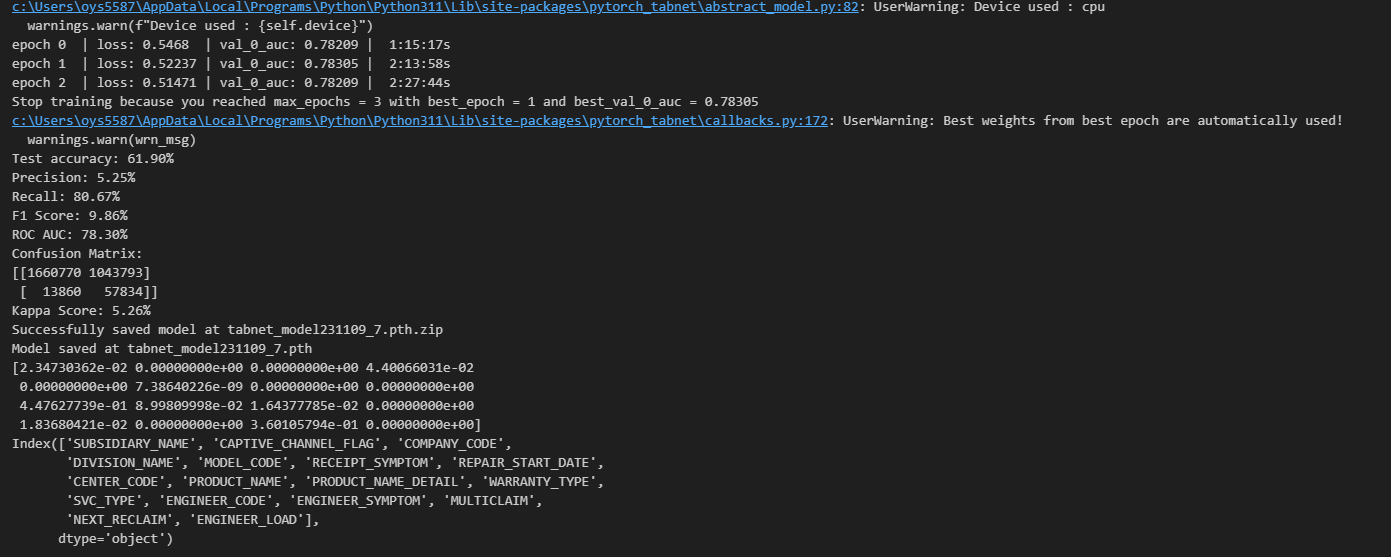